In [5]:
import sys
print(sys.executable)

E:\anaconda\python.exe


In [6]:
!where python
import sys
print(sys.executable)


E:\anaconda\python.exe
C:\Users\user\AppData\Local\Microsoft\WindowsApps\python.exe
E:\anaconda\python.exe


In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Paths and constants
INPUT_DATASET = "breastCancerData/original"
BASE_PATH = "breastCancerData/idc"
TRAIN_PATH = os.path.join(BASE_PATH, "training")
VAL_PATH = os.path.join(BASE_PATH, "validation")
TEST_PATH = os.path.join(BASE_PATH, "testing")
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
BS = 32
NUM_EPOCHS = 1
INIT_LR = 1e-2

In [3]:
# Create base path if it doesn't exist
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)

In [4]:
# Load and shuffle image paths
originalPaths = list(paths.list_images(INPUT_DATASET))
random.seed(7)
random.shuffle(originalPaths)

In [5]:
# Split into train, val, test
index = int(len(originalPaths) * TRAIN_SPLIT)
trainPaths = originalPaths[:index]
testPaths = originalPaths[index:]

index = int(len(trainPaths) * VAL_SPLIT)
valPaths = trainPaths[:index]
trainPaths = trainPaths[index:]

In [6]:
datasets = [("training", trainPaths, TRAIN_PATH),
            ("validation", valPaths, VAL_PATH),
            ("testing", testPaths, TEST_PATH)]

for (setType, imagePaths, basePath) in datasets:
    print(f"Building {setType} set")
    if not os.path.exists(basePath):
        os.makedirs(basePath)

    for path in imagePaths:
        file = path.split(os.path.sep)[-1]
        label = file[-5:-4]
        labelPath = os.path.join(basePath, label)

        if not os.path.exists(labelPath):
            os.makedirs(labelPath)

        newPath = os.path.join(labelPath, file)
        if not os.path.exists(newPath):
            shutil.copy2(path, newPath)


Building training set
Building validation set
Building testing set


In [7]:
# Model Definition
class CancerNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = tf.keras.models.Sequential()
        shape = (height, width, depth)
        channelDim = -1

        if K.image_data_format() == "channels_first":
            shape = (depth, height, width)
            channelDim = 1

        model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=shape))
        model.add(tf.keras.layers.BatchNormalization(axis=channelDim))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Dropout(0.25))

        model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(tf.keras.layers.BatchNormalization(axis=channelDim))
        model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(tf.keras.layers.BatchNormalization(axis=channelDim))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Dropout(0.25))

        model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(tf.keras.layers.BatchNormalization(axis=channelDim))
        model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(tf.keras.layers.BatchNormalization(axis=channelDim))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Dropout(0.25))

        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(256, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.Dense(classes, activation='softmax'))

        return model

In [8]:
# Image Generators
trainAug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

valAug = ImageDataGenerator(rescale=1./255)

trainGen = trainAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="categorical",
    target_size=(48, 48),
    color_mode="rgb",
    shuffle=True,
    batch_size=BS
)

valGen = valAug.flow_from_directory(
    VAL_PATH,
    class_mode="categorical",
    target_size=(48, 48),
    color_mode="rgb",
    shuffle=False,
    batch_size=BS
)

testGen = valAug.flow_from_directory(
    TEST_PATH,
    class_mode="categorical",
    target_size=(48, 48),
    color_mode="rgb",
    shuffle=False,
    batch_size=BS
)

Found 199818 images belonging to 2 classes.
Found 22201 images belonging to 2 classes.
Found 55505 images belonging to 2 classes.


In [9]:
# Compute class weights
trainPaths = list(paths.list_images(TRAIN_PATH))
trainLabels = [int(p.split(os.path.sep)[-2]) for p in trainPaths]
from tensorflow.keras.utils import to_categorical
trainLabels = to_categorical(trainLabels, num_classes=2)

classTotals = trainLabels.sum(axis=0)
classWeight = classTotals.max() / classTotals

# Build and compile model
model = CancerNet.build(width=48, height=48, depth=3, classes=2)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
H = model.fit(
    x=trainGen,
    validation_data=valGen,
    epochs=NUM_EPOCHS
)


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6245/6245 ━━━━━━━━━━━━━━━━━━━━ 4582s 731ms/step - accuracy: 0.8219 - loss: 0.4305 - val_accuracy: 0.7756 - val_loss: 0.4991


In [10]:
# Evaluate the model
print("Now evaluating the model")
testGen.reset()
lenTest = len(list(paths.list_images(TEST_PATH)))
pred_indices = model.predict(testGen, steps=(lenTest // BS) + 1)
pred_indices = np.argmax(pred_indices, axis=1)

print(classification_report(testGen.classes, pred_indices,
                            target_names=testGen.class_indices.keys()))

# Confusion matrix and metrics
cm = confusion_matrix(testGen.classes, pred_indices)
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print(cm)
print(f"Accuracy: {accuracy}")
print(f"Specificity: {specificity}")
print(f"Sensitivity: {sensitivity}")

Now evaluating the model
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 1233s 710ms/step
              precision    recall  f1-score   support

           0       0.77      0.98      0.87     39736
           1       0.86      0.28      0.42     15769

    accuracy                           0.78     55505
   macro avg       0.82      0.63      0.64     55505
weighted avg       0.80      0.78      0.74     55505

[[39009   727]
 [11386  4383]]
Accuracy: 0.7817674083415909
Specificity: 0.27795040903037604
Sensitivity: 0.9817042480370445


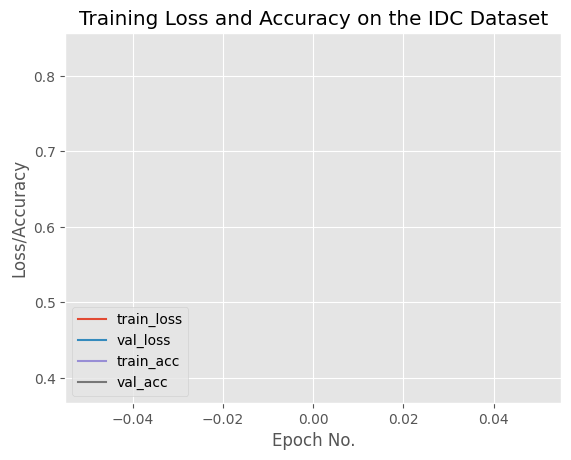

In [11]:
# Plot training history
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on the IDC Dataset")
plt.xlabel("Epoch No.")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")